In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [29]:
def get_stim_resp(pp,y):
    n_rois = y.shape[0]
    frame_times = np.array(pp.metadata['frame_times']).mean(axis=1)
    
    stim_times = [pp.metadata['mark_points']['initial_delay']]
    for i in range(pp.metadata['mark_points']['repetitions']-1):
        stim_times.append(pp.metadata['mark_points']['inter_point_delay']+pp.metadata['mark_points']['duration'])
    stim_times = np.array(stim_times)/1000
    stim_times = np.cumsum(stim_times)
    
    stim_inds = []
    for time in stim_times:
        stim_inds.append( np.argwhere((frame_times-time)>0)[0][0])
    stim_inds = np.array(stim_inds)
    
    for ind in stim_inds:
        y[ind-1:ind+1] = np.nan
    # y[stim_inds]=np.nan
    # y[stim_inds-1]=np.nan
    # y[stim_inds+1]=np.nan
    
    stim_resp = np.zeros((len(stim_inds)-1,  50))
    for i, ind in enumerate(stim_inds[1:]):
        stim_resp[i,:] = y[ind-10:ind+40]
    stim_resp /= np.nanmean(stim_resp[:,:10], axis=-1, keepdims=True)
    # stim_resp[:,:9] = sp.ndimage.gaussian_filter1d(stim_resp[:,:9],1,axis=-1)
    # stim_resp[:,12:] = sp.ndimage.gaussian_filter1d(stim_resp[:,12:],1,axis=-1)
    
    return stim_resp

In [30]:

bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
fictrac_folder = pathlib.PurePath('/media/mplitt/SSD_storage/fictrac_folder')
                            

# sessions = ['baseline_stim-001', 'DA_washon_stim-002', 'post_DA_washon_stim-003', 'OA_washon_stim-004', 'post_OA_washon_stim-006']
# sessions = ['baseline_stim-001', 'DA_washon_stim-002', 'OA_washon_stim-004']
# sessions = ['baseline_stim-000', 'post_DA_washon_stim-003', 'post_OA_washon_stim-005']
sessions = ['baseline-000', 'DA-002', 'OA-005']


gd = 'ER4d_Chrimson88tdT_sytjGCaMP7f'
d = '18_04_2024'
f = 'fly1'

stim_resp_list = []
for s in sessions:
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    dt = pp.metadata['frame_period']*pp.metadata['layout']['frames_per_sequence']
    print(dt)
    y = pp.calculate_zscored_F('outer_ring', exp_detrend=True,zscore=False)[1,0,:]
    # y = sp.ndimage.median_filter(y,3)
    
    stim_resp_list.append(get_stim_resp(pp,y))

0.10776626
0.107767135
0.107768192


/tmp/ipykernel_1973486/817295169.py:6: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(stim_resp_list[0]-1,axis=0)
/tmp/ipykernel_1973486/817295169.py:11: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(stim_resp_list[1]-1,axis=0)
/tmp/ipykernel_1973486/817295169.py:17: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(stim_resp_list[1]-1,axis=0)
/tmp/ipykernel_1973486/817295169.py:22: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(stim_resp_list[2]-1,axis=0)


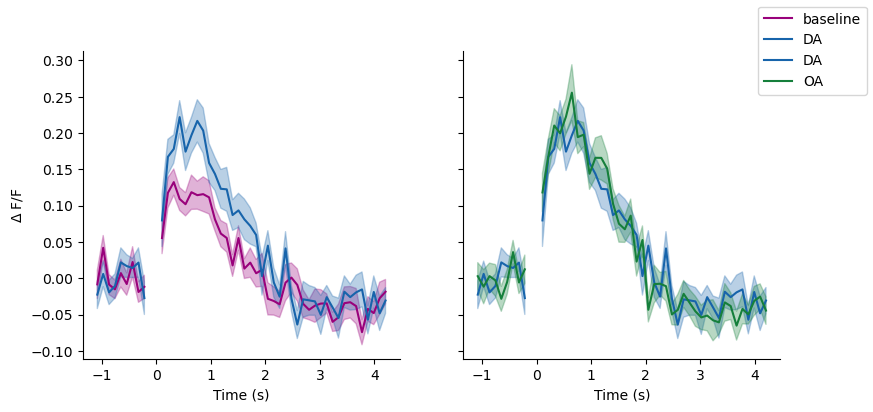

In [31]:
fig, ax = plt.subplots(1,2, figsize=[9,4], sharey=True, sharex=True)

x = np.arange(-10*dt,40*dt-dt/4,dt)
colors = ['blue', 'green','red']

mu = np.nanmean(stim_resp_list[0]-1,axis=0)
sem = sp.stats.sem(stim_resp_list[0]-1,axis=0, nan_policy='omit')    
ax[0].plot(x, mu, color= plt.cm.RdPu(.8), label='baseline')
ax[0].fill_between(x, mu-sem, mu+sem, color= plt.cm.RdPu(.8), alpha=.3)

mu = np.nanmean(stim_resp_list[1]-1,axis=0)
sem = sp.stats.sem(stim_resp_list[1]-1, axis=0, nan_policy='omit')    
ax[0].plot(x, mu, color= plt.cm.Blues(.8), label = 'DA')
ax[0].fill_between(x, mu-sem, mu+sem, color= plt.cm.Blues(.8), alpha=.3)


mu = np.nanmean(stim_resp_list[1]-1,axis=0)
sem = sp.stats.sem(stim_resp_list[1]-1,axis=0, nan_policy='omit')    
ax[1].plot(x, mu, color= plt.cm.Blues(.8), label = 'DA')
ax[1].fill_between(x, mu-sem, mu+sem, color= plt.cm.Blues(.8), alpha=.3)

mu = np.nanmean(stim_resp_list[2]-1,axis=0)
sem = sp.stats.sem(stim_resp_list[2]-1,axis=0, nan_policy='omit')    
ax[1].plot(x, mu, color= plt.cm.Greens(.8), label='OA')
ax[1].fill_between(x, mu-sem, mu+sem, color= plt.cm.Greens(.8), alpha=.3)


for a in range(2):
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_xlabel('Time (s)')
ax[0].set_ylabel(r"$\Delta$ F/F")

fig.legend()
fig.savefig('/media/mplitt/SSD_storage/fig_scratch/cosyne_2024/poster/ex_vivo_pilot/bath_application.pdf')

86.0 0.7380905151367188
[0.06762515921276524, 0.13047073530293285, 0.13548867801948528]
86.0 4.449730962909332e-06


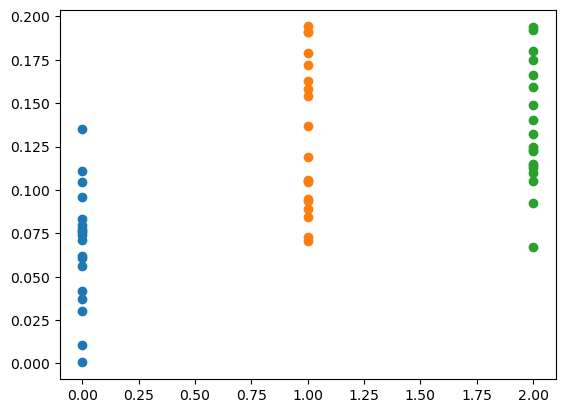

In [32]:
fig, ax = plt.subplots()
for i, sr in enumerate(stim_resp_list):
    r = np.nanmean(sr[:,12:30],axis=-1)-1
    ax.scatter(np.zeros_like(r)+i, r)

t, p = sp.stats.wilcoxon(stim_resp_list[2][:,12:30].mean(axis=-1),stim_resp_list[1][:,12:30].mean(axis=-1))
print(t,p)
print([sr[:,12:30].mean(axis=-1).mean()-1 for sr in stim_resp_list])

f, p = sp.stats.kruskal(stim_resp_list[0][:,12:30].mean(axis=-1),stim_resp_list[1][:,12:30].mean(axis=-1),stim_resp_list[2][:,12:30].mean(axis=-1))
print(t,p)

In [7]:
# 